# Zaidel `MF6Adj` Demo #

This problem uses the well known Zaidel problem presented in __[Zaidel (2003)](https://ngwa.onlinelibrary.wiley.com/doi/10.1111/gwat.12019)__ to test out the adjoint tool. The Zaidel problem is most often used to verify the numerical stability and convergence of a computer code against a discontinous, steady-state analytical solution of the Boussinesq equation. Here, we use it as a vehicle for understanding the utility of `Mf6Adj`

The learning objectives include:
1. Build and solve adjoint for the Zaidel problem using a direct head performance measure (PM).
2. Understand the adjoint sensitivity results. 
3. Explore the adjoint sensitivity results for a different PM location. 

First, we need to do some bookeeping: import libraries, set paths, create directories, ensure executables are in the working directory.

In [1136]:
import os
import platform
import sys
import shutil
from datetime import datetime
import h5py
import numpy as np
import pandas as pd
import pathlib as pl
import flopy
import matplotlib.pyplot as plt
from flopy.plot.styles import styles
import pyemu

sim_name = "ex-gwf-zaidel"
workspace = sim_name
if not os.path.exists(workspace):
    os.mkdir(workspace)

In [1137]:
if "linux" in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "linux", "libmf6.so")
    mf6_bin = os.path.join("..", "bin", "linux", "mf6")
    local_lib_name = "./libmf6.so"
    local_mf6_bin = "./mf6"
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower() and "arm" not in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "mac", "libmf6.dylib")
    mf6_bin = os.path.join("..", "bin", "mac", "mf6")
    local_lib_name = "./libmf6.dylib"
    local_mf6_bin = "./mf6"
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower() and "arm" in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "mac", "libmf6_arm.dylib")
    mf6_bin = os.path.join("..", "bin", "mac", "mf6")
    local_lib_name = "./libmf6_arm.dylib"
    local_mf6_bin = "./mf6"
else:
    lib_name = os.path.join("..", "bin", "win", "libmf6.dll")
    mf6_bin = os.path.join("..", "bin", "win", "mf6.exe")
    local_lib_name = "libmf6.dll"
    local_mf6_bin = "mf6.exe"

In [1138]:
try:
    shutil.copy2(lib_name,os.path.join(workspace,os.path.split(local_lib_name)[1]))
    shutil.copy2(mf6_bin,os.path.join(workspace,os.path.split(local_mf6_bin)[1]))
    shutil.copytree(os.path.join('..','autotest','xmipy'), os.path.join(workspace, 'xmipy'))
    shutil.copytree(os.path.join('..','autotest','bmipy'), os.path.join(workspace, 'bmipy'))
    shutil.copytree(os.path.join('..','autotest','modflowapi'), os.path.join(workspace, 'modflowapi'))
    shutil.copytree(os.path.join('..','autotest','flopy'), os.path.join(workspace, 'flopy'))
    shutil.copytree(os.path.join('..','mf6adj'), os.path.join(workspace,"mf6adj"))
except:
    print('bins already in dir')

bins already in dir


The Zaidel model comprises a steady-state, 1 stress period (SP), 1 timestep (TS), 2-dimensional, stair-stepped domain with a constant head boundary condition (BC) at both ends dictating the head gradient. No other BCs are applied. At the time of developing this notebook example (October 2024), `Mf6Adj` was not yet able to handle constant head (CHD) BCs, so we will apply the well-known trick of using a general head BC with a high conductance to imitate a CHD. 

We are going to wrap our model build/run calls into a function to allow us to test some things later on in this example. 

In [1139]:
# Model units
length_units = "meters"
time_units = "days"

def run_model(H2=1,k11=0.0001,hclose=1e-9,rclose=1e-6,nouter=500,ninner=50,cond=100):

    # Model parameters
    nper = 1  # Number of periods
    nlay = 1  # Number of layers
    nrow = 1  # Number of rows
    ncol = 200  # Number of columns
    delr = 5.0  # Column width ($m$)
    delc = 1.0  # Row width ($m$)
    top = 25.0  # Top of the model ($m$)
    strt = 23.0  # Starting head ($m$)
    icelltype = 1  # Cell conversion type
    H1 = 23.0  # Constant head in column 1 ($m$)
    
    
    # Time discretization
    tdis_ds = ((1.0, 1, 1.0),)
    
    # Build stairway bottom
    botm = np.zeros((nlay, nrow, ncol), dtype=float)
    base = 20.0
    for j in range(ncol):
        botm[0, :, j] = base
        if j + 1 in (40, 80, 120, 160):
            base -= 5

    # Constant head cells are specified on the left and right edge of the model
    chd_spd = [
        [0, 0, 0, H1,cond],
        [0, 0, ncol - 1, H2,cond],
    ]
    
    sim_ws = os.path.join(workspace)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, newtonoptions="newton")
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfghb(gwf, stress_period_data=chd_spd)
    
    head_filerecord = f"{sim_name}.hds"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        saverecord=[("HEAD", "ALL")],
    )
    
    sim.write_simulation()
    pyemu.os_utils.run('mf6',cwd=workspace)

Let's wrap the plotting code bits into a function as well, this time just for brevity's sake.

In [1140]:
def plot_results(plot_head=False,arr=None,arr_label='',ws=workspace,plot_pm=False,pm_col=0):
    sim = flopy.mf6.MFSimulation.load(sim_ws = ws)
    gwf = sim.get_model()

    xedge = gwf.modelgrid.xvertices[0]
    zedge = np.array([botm[0, 0, 0]] + botm.flatten().tolist())

    # create MODFLOW 6 head object
    hobj = gwf.output.head()
    
    # extract heads
    head = hobj.get_data()
    
    # Create figure for simulation
    extents = (0, ncol * delr, -1, 25.0)
    figure_size = (6.3, 2.5)
    fig, ax = plt.subplots(
        ncols=1,
        nrows=1,
        figsize=figure_size,
        dpi=300,
        constrained_layout=True,
        sharey=True,
    )
    
    ax.set_xlim(extents[:2])
    ax.set_ylim(extents[2:])
    
    fmp = flopy.plot.PlotCrossSection(
        model=gwf, ax=ax, extent=extents, line={"row": 0}
    )
    ax.fill_between(xedge, zedge, y2=-1, color="0.75", step="pre", lw=0.0)
    if plot_head:
        vmin, vmax = 0, 25
        plot_obj = fmp.plot_array(head, head=head, vmin=vmin, vmax=vmax)
        cb_label=r"Head, $m$"
    else:
        plot_obj = fmp.plot_array(arr,head=head)
        cb_label=arr_label

    if plot_pm:
        height = head[0,0,pm_col]
        ax.plot((pm_col*5)+2.5, height, '*',color='red',ms=5)
    ax.set_xlabel("x-coordinate, in meters")
    ax.set_ylabel("Elevation, in meters")
    
    # create legend
    ax.plot(
        -10000,
        -10000,
        lw=0,
        marker="s",
        ms=10,
        mfc="cyan",
        mec="cyan",
        label="Constant Head",
    )
    ax.plot(
        -10000,
        -10000,
        lw=0,
        marker="s",
        ms=10,
        mfc="0.75",
        mec="0.75",
        label="Model Base",
    )
    # styles.graph_legend(ax, ncol=2, loc="upper right")
    
    # plot colorbar
    cax = plt.axes([0.62, 0.86, 0.325, 0.025])
    cbar = plt.colorbar(plot_obj, shrink=0.8, orientation="horizontal", cax=cax)
    cbar.ax.tick_params(size=0)
    cbar.ax.set_xlabel(f'{cb_label}', fontsize=9)

Let's run the model and plot the heads. We should (hopefully) see a converged solution and a fun stair-stepping pattern in heads.  

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ex-gwf-zaidel...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:59:05 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software a

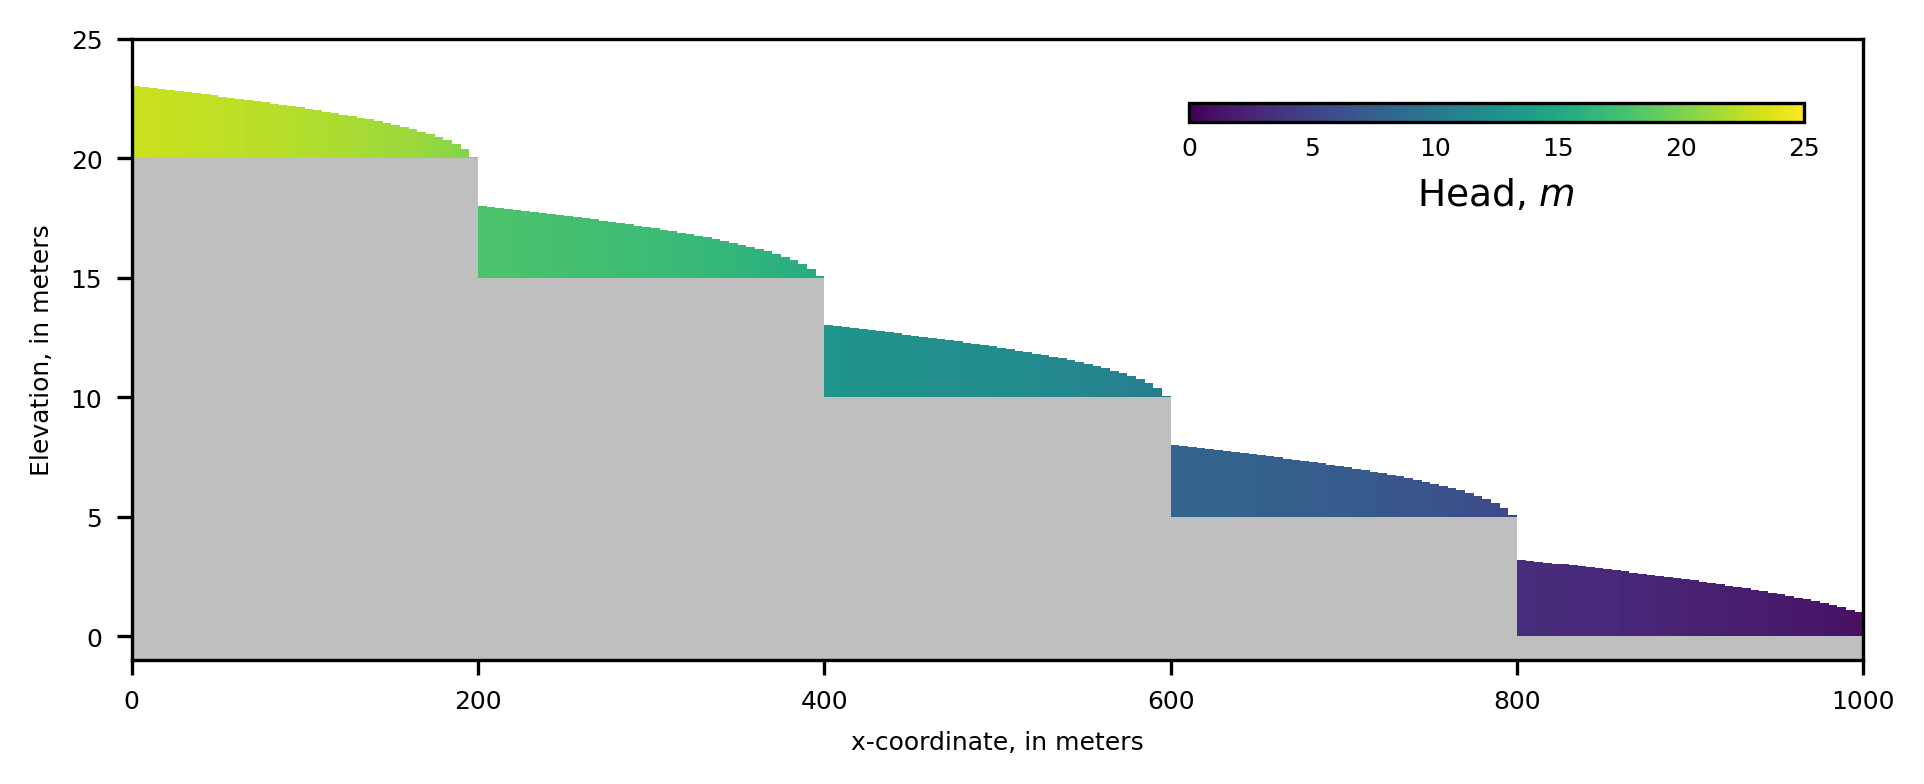

In [1141]:
run_model()
plot_results(plot_head=True)

Et voila! Now let's try a direct head performance measure (PM) with adjoint. There's just one stress period, so no need to add multiple PMs for the same location.

In [1142]:
pm_fname = "zaidel_perfmeas.dat"
fpm = open(os.path.join(workspace,pm_fname),'w')
pm_col = 190 #pm column
l,r = 1,1 # the layer row
sp,ts = 1,1 #stress period and time step
pm_name = "pm_single"
fpm.write("begin performance_measure {0}\n".format(pm_name))
fpm.write("{0} {1} {2} {3} {4} head direct 1.0 -1e30\n".format(sp,ts,l,r,pm_col))
fpm.write("end performance_measure\n\n")
fpm.close()

Now let's run the adjoint solution. Recall this involves a single forward run of the model and then a solve of the adjoint state for each SP and TS, backwards in time. 

In [1143]:
bd = os.getcwd()
os.chdir(workspace)

In [1144]:
forward_hdf5_name = "zaidel.hdf5"
start = datetime.now()
import mf6adj
adj = mf6adj.Mf6Adj(pm_fname,os.path.split(local_lib_name)[1],verbose_level=2)
adj.solve_gwf(hdf5_name=forward_hdf5_name) # solve the standard forward solution
dfsum = adj.solve_adjoint() # solve the adjoint state for each performance measure
adj.finalize() #release components
duration = (datetime.now() - start).total_seconds()
print("took:",duration)

...structured grid found
...starting flow solution at 2024-10-03 13:41:52
flow stress period,time step 1,1 converged with 64 iters, took 6.5483E-05 mins

...flow solution finished at 2024-10-03 13:41:52, took: 0.00010977 mins


...structured grid found, shape: (1, 1, 200)
solving adjoint solution for PerfMeas: pm_single  (kper,kstp) (0, 0)
took: 0.033447


In [1145]:
os.chdir(bd)

Looks like it ran, yay! Now let's check out what output files are in the working directory. Recall, `Mf6Adj` stores outputs in a heirarchical data (HDF5) format. This is necessary because the adjoint solution would otherwise have to store quite a lot of information from the forward run (conductance, RHS, etc.) in memory. Plus, it avoids saving out the adjoint results to tons of ascii files that can clutter up the working directory fast.

In [1146]:
[f for f in os.listdir(workspace) if f.endswith("hdf5")]

['zaidel.hdf5', 'adjoint_solution_pm_single_zaidel.hdf5']

The zaidel hdf5 file contains the forward run components, whereas the adjoint solution hdf5 file contains the outputs we are after. Let's take a look at what's in the results file. It should be all timesteps/stress periods for all performance measure, which in our case is just 1 for now.

In [1147]:
result_hdf = "adjoint_solution_pm_single_zaidel.hdf5"
hdf = h5py.File(os.path.join(workspace,result_hdf),'r')
keys = list(hdf.keys())
keys.sort()
keys

['composite', 'solution_kper:00000_kstp:00000']

Now let's investigate the components for which we have sensitivity results for that direct head PM. There should be one for every BC parameter in the model, as well as K components. 

In [1148]:
grp = hdf["composite"]
plot_keys = [i for i in grp.keys() if len(grp[i].shape) == 3]
plot_keys

['ghb_0_bhead', 'ghb_0_cond', 'k11', 'k33', 'rch6_recharge', 'wel6_q']

__But wait!__ There are results for two extra BCs that were not part of the Zaidel model: the recharge and well package. Why is that?

This is because the adjoint state is equivalent the sensitivity of the PM to a unit injection of water in every cell. A unit injection of water is equal to a specified flux BC, or the recharge and well package (assuming Q is positive for injection in the well package).

#### So for any `Mf6Adj` solution, you automatically get the sensitivity of the PM to recharge and well Q regardless of them being in the model.

All right, now let's plot up the results and see if they make sense. Let's start with the GHB parameters: GHB head and conductance.

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package ghb...
    loading package oc...
  loading solution package ex-gwf-zaidel...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package ghb...
    loading package oc...
  loading solution package ex-gwf-zaidel...


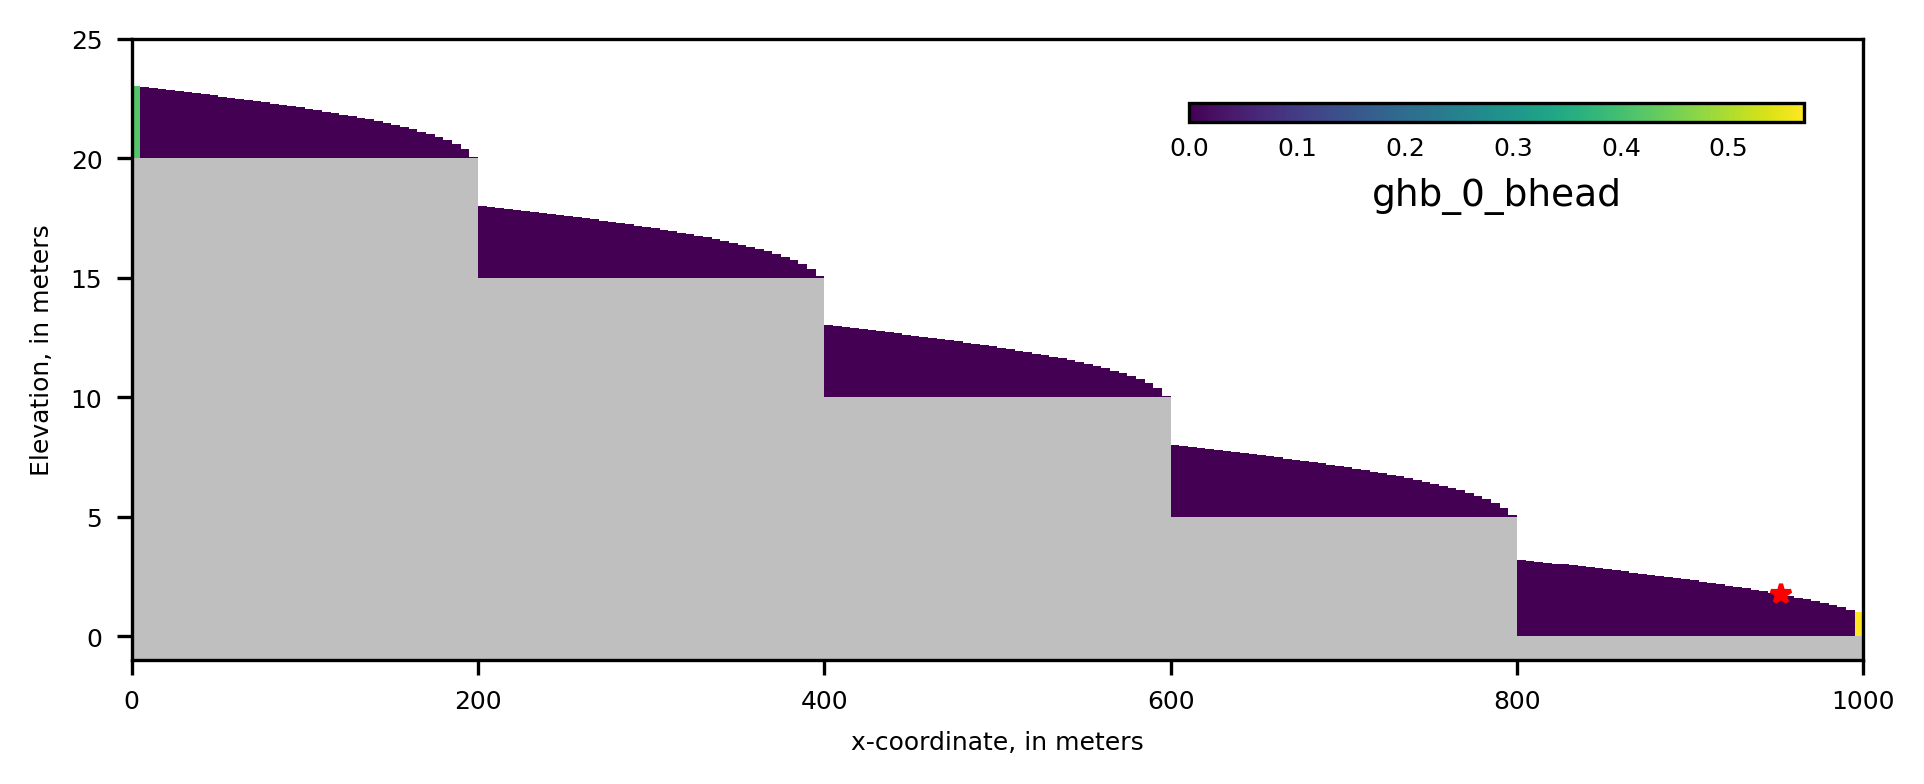

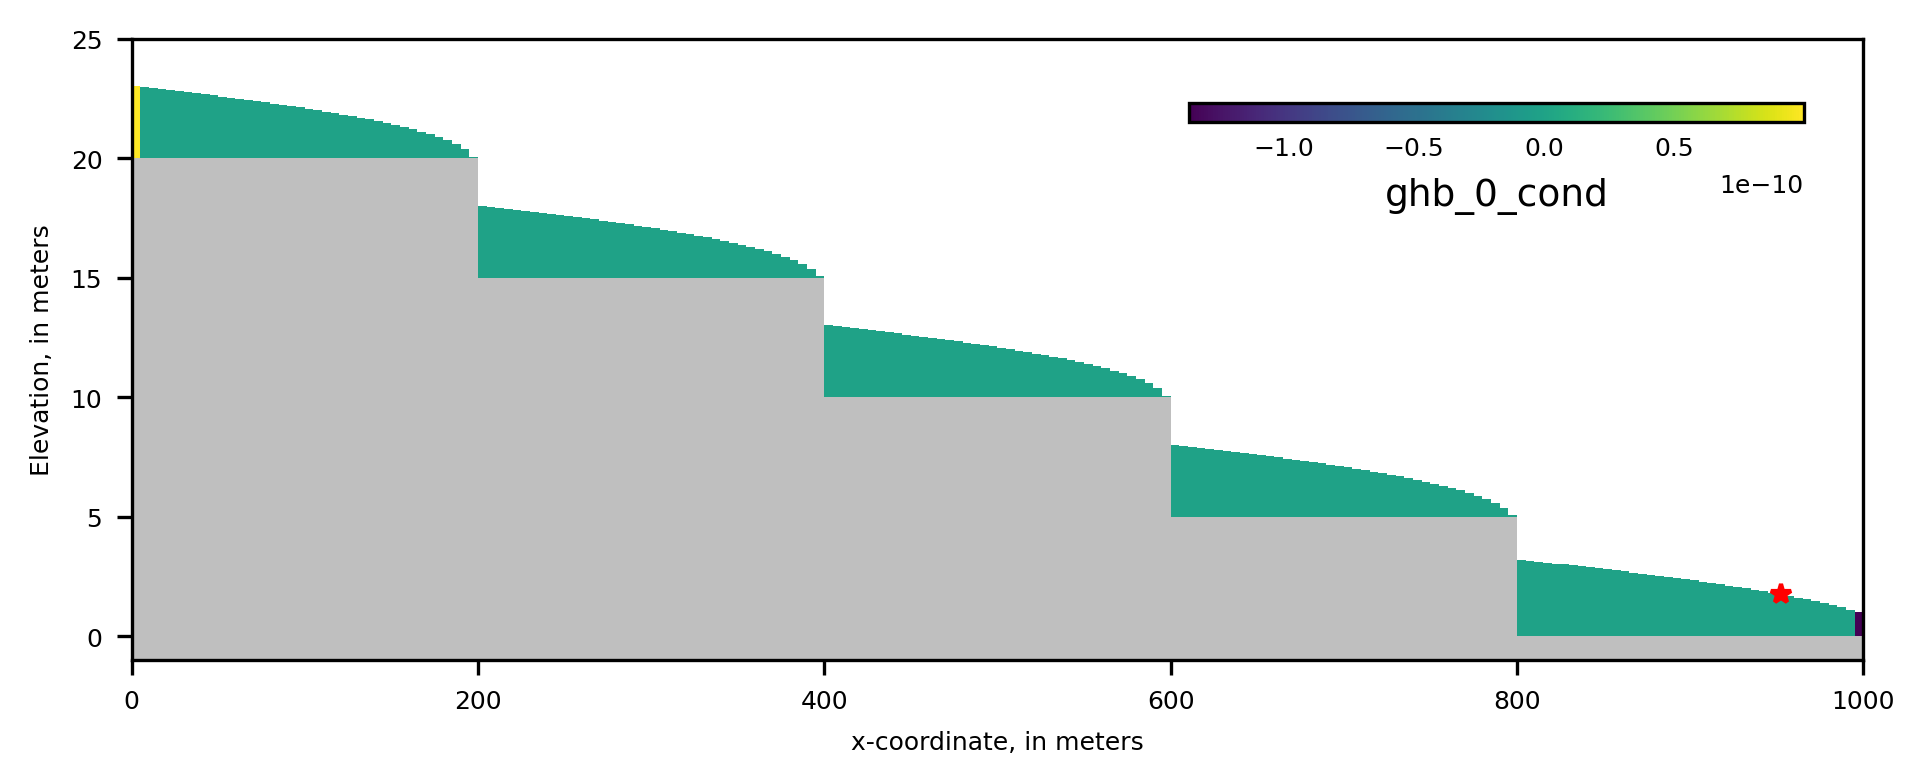

In [1149]:
keys = [pkey for pkey in plot_keys if 'ghb' in pkey]
for pkey in keys:
    arr = grp[pkey][:]
    for k,karr in enumerate(arr):
        plot_results(arr=karr,plot_head=False,arr_label=pkey,plot_pm=True,pm_col=pm_col)

Cool! The adjoint results show that the head PM is more sensitive to GHB head than conductance. That makes intuitive sense, since conductance is much larger than head in this example and typically varies over a larger scale, so heads would be less responsive to a unit change in conductance. 

Another interesting result is in the relative sensitivities of the upgradient and downgradient GHBs. For GHB head, it makes sense that head in column 190 would be more sensitive to the downgradient GHB. 

__But why does the downgradient GHB show a negative sensitivity value and the upgradient GHB a positive sensitivity value?__

The adjoint method solves for the response of the PM to a positive increment in the parameter. So, for the upgradient GHB, a higher conductance means slightly more flux into the domain and higher downgradient head. For the downgradient GHB, a higher conductance would act to flatten the the water table at that lowest step, leading to a slightly lower head at the PM. __Conductance up, head up is a positivie sensitivity, conductance up, head down is a negative sensitivity.__ 

Now let's take a look at the components of K: K11 and K33 (horizontal and vertical K)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package ghb...
    loading package oc...
  loading solution package ex-gwf-zaidel...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package ghb...
    loading package oc...
  loading solution package ex-gwf-zaidel...


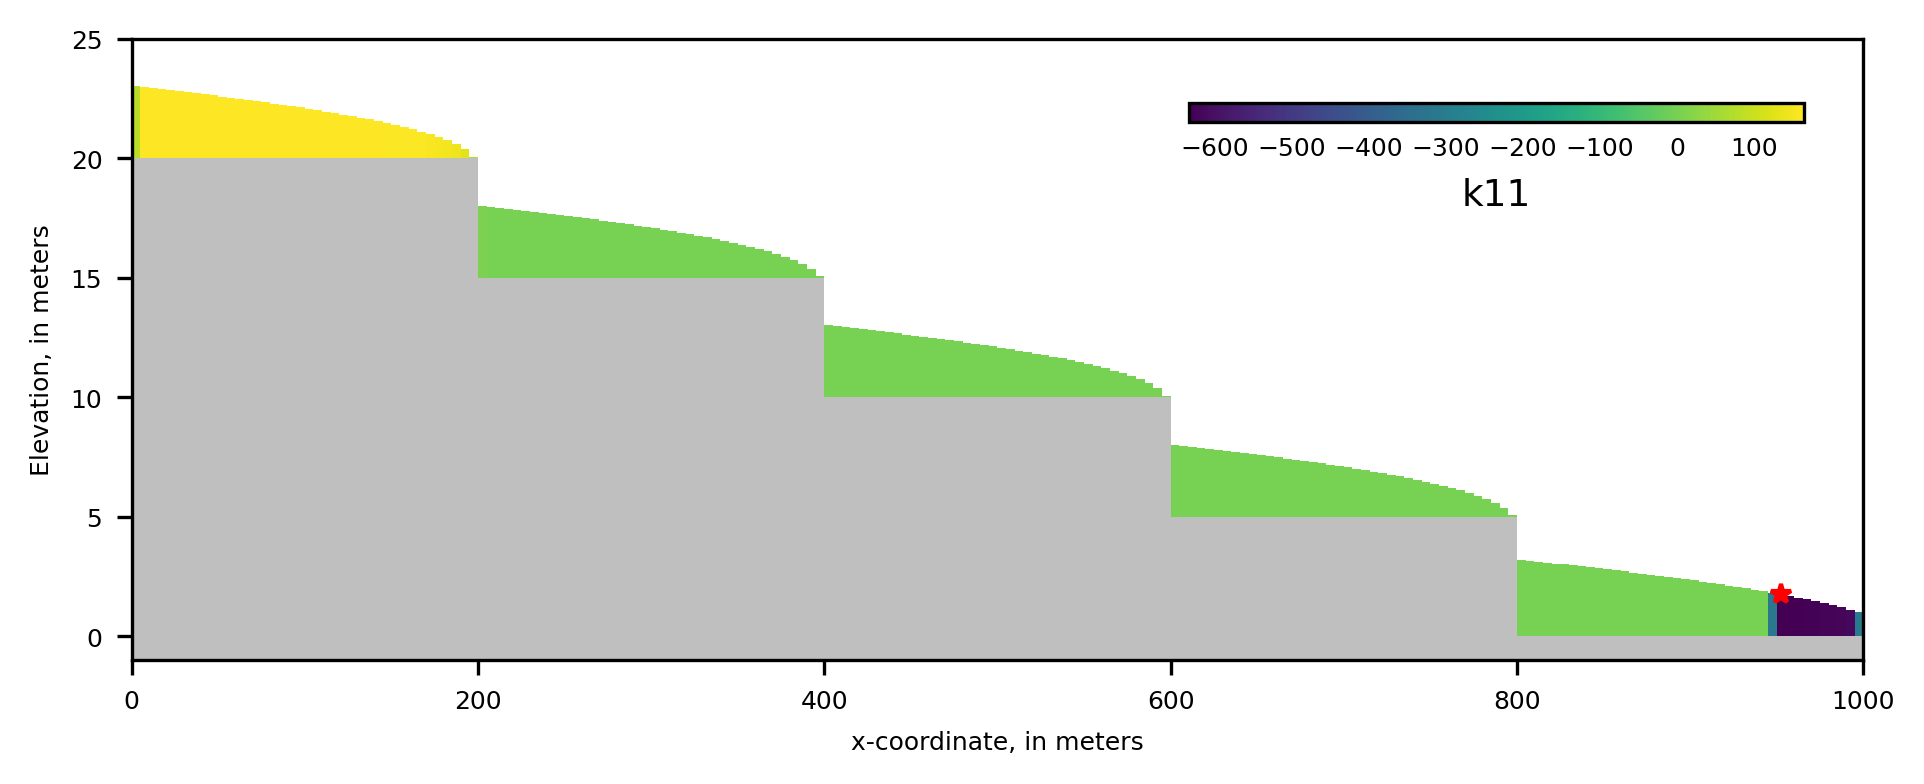

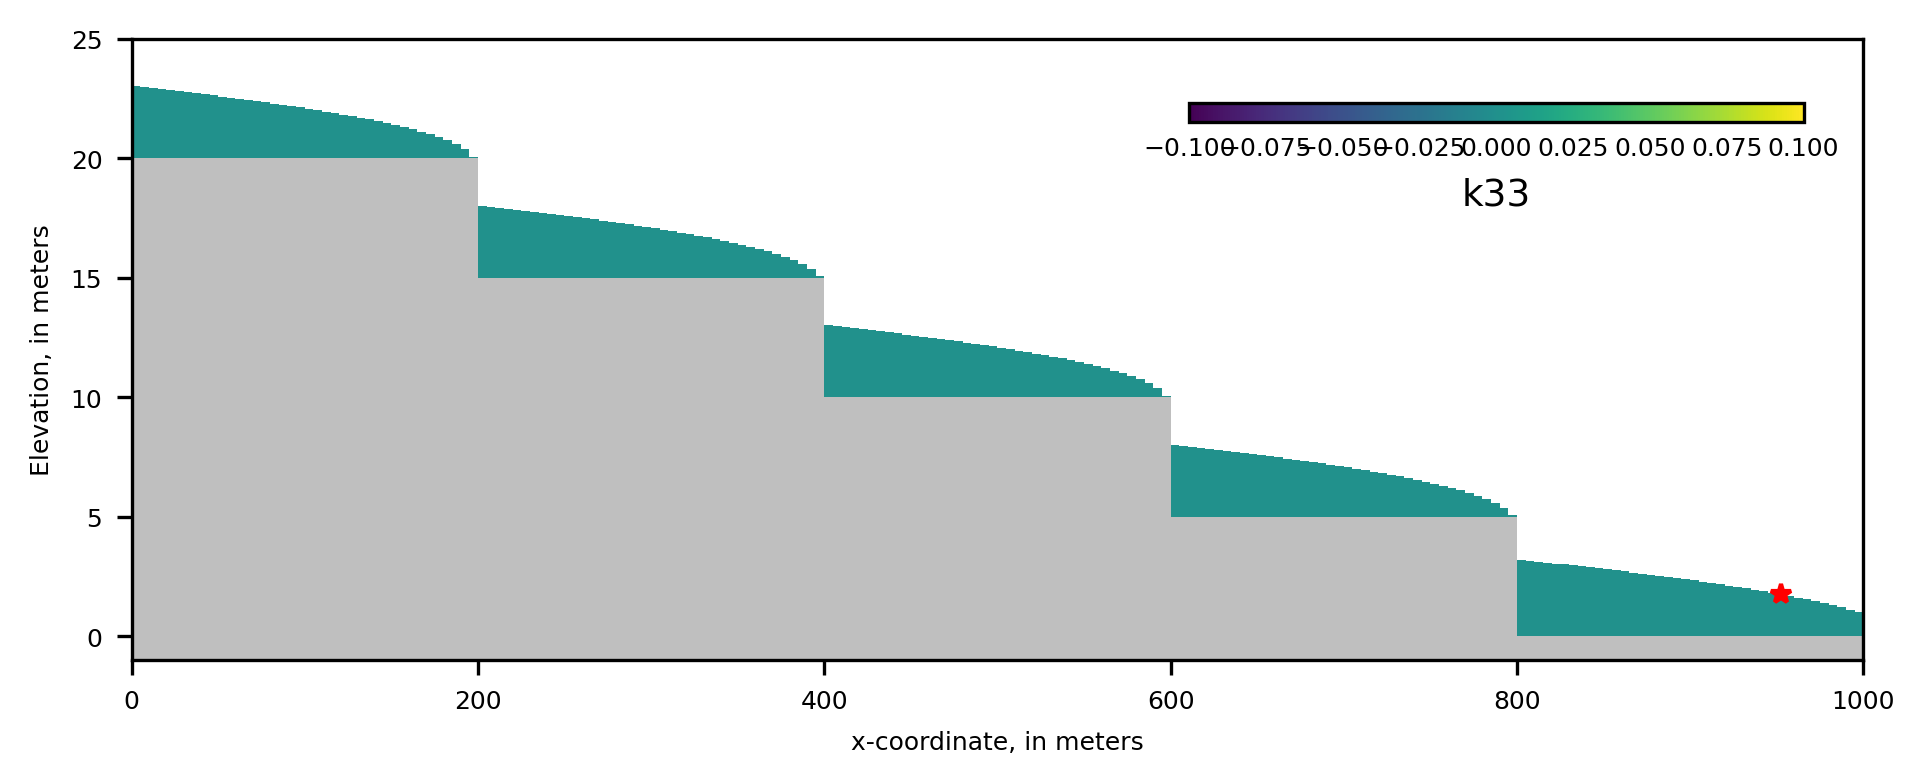

In [1150]:
keys = [pkey for pkey in plot_keys if 'k' in pkey]
for pkey in keys:
    arr = grp[pkey][:]
    for k,karr in enumerate(arr):
        plot_results(arr=karr,plot_head=False,arr_label=pkey,plot_pm=True,pm_col=pm_col)

Wait, why is K33 zero sensitivity everywhere?

###### Because it's a 1-layer model, doh! 

__So what's up with the zonal behavior with K11?__

Just like with the GHB conductance, a higher K at the upgradient step containing the GHB leads to more flow into the domain and a higher head PM. A higher K downgradient of the PM (but on the same step) would act to flatten the water table and lead to a lower head PM. K values at the GHB locations have lower absolute sensitivities, reflecting the dominance of the BC conductance in those cells. Interestingly, horizontal K at all of the intervening upgradient steps has very small (but not zero) positive sensitivity. This reflects the fact that the heads in the Zaidel problem are largely governed by the GHBs.

Last but not least, let's take a look at the recharge and well results. 

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package ghb...
    loading package oc...
  loading solution package ex-gwf-zaidel...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package ghb...
    loading package oc...
  loading solution package ex-gwf-zaidel...


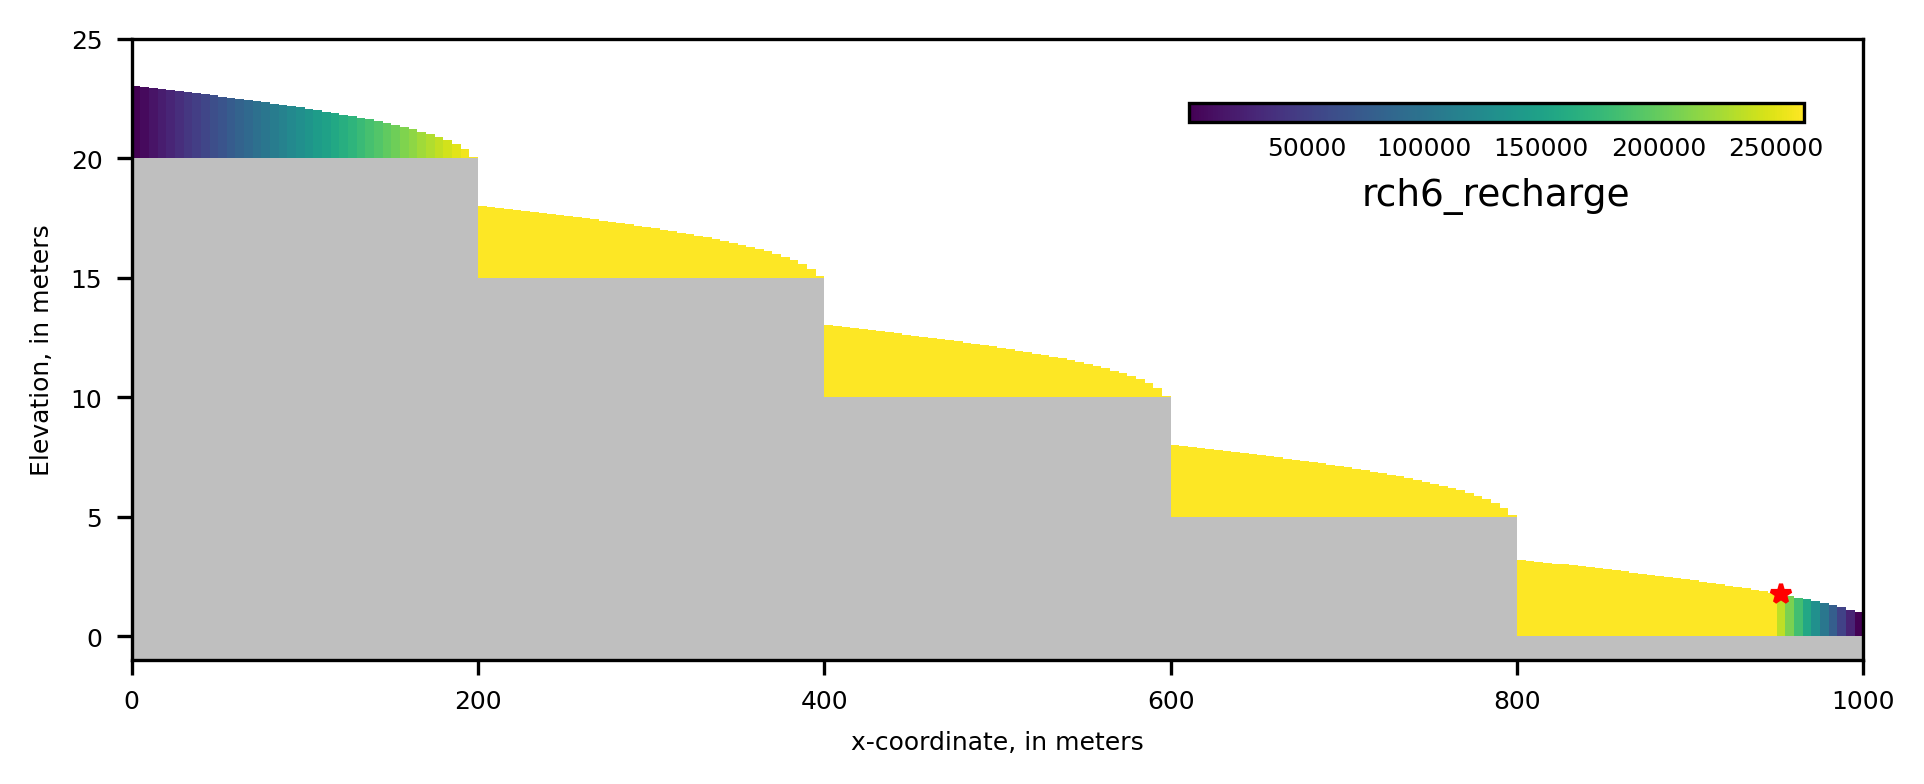

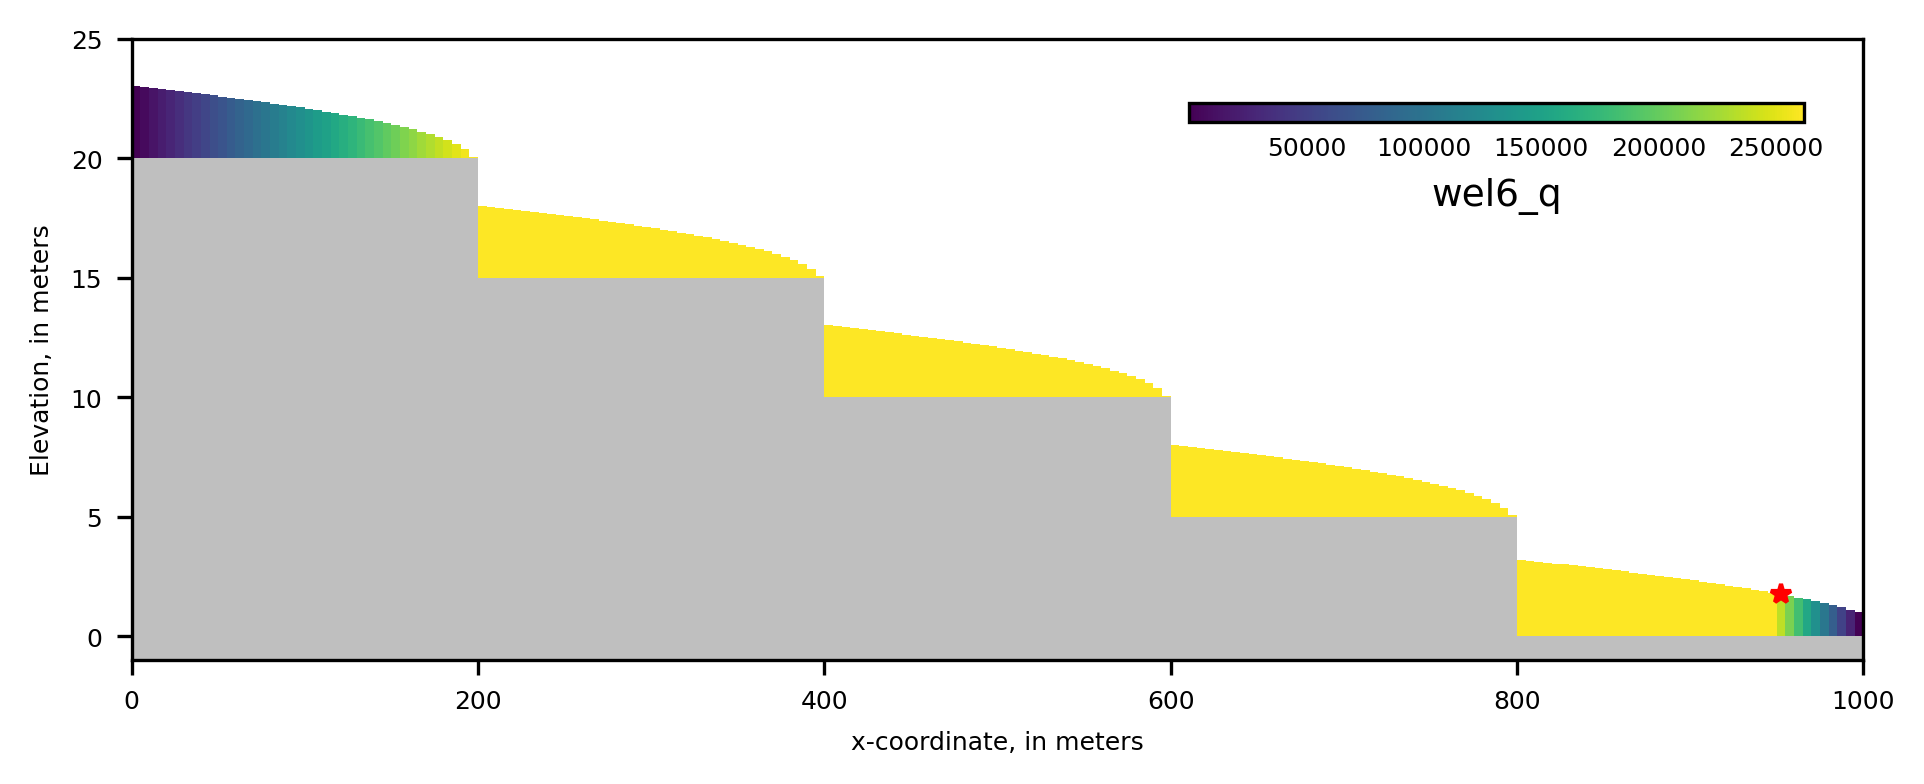

In [1151]:
keys = [pkey for pkey in plot_keys if 'rch' in pkey or 'wel' in pkey]
for pkey in keys:
    arr = grp[pkey][:]
    for k,karr in enumerate(arr):
        plot_results(arr=karr,plot_head=False,arr_label=pkey,plot_pm=True,pm_col=pm_col)

As expected, they are identical. This is because neither package exists in the model, and so they reflect the sensitivity of the direct head PM to a unit injection of water. But let's unpack these results a bit further...

Recharge/well Q downgradient of the PM shows decreasing sensitivity the further you move away from the PM. Because the problem is discontinuous, we would expect that sensitivity to drop to zero at the next lower stair step to the head PM. Conversely, upgradient sensitivity is uniformly high until the furthest upgradient step is reached, where the sensitivity drops lower as it approaches the upgradient GHB. This reflects the interplay between unit injection of water and the fixed GHB head.

#### Let's test our adjoint understanding a bit. What happens if we put the direct head PM in the middle of the domain now?

__Self-Learning:__ Walk through the results and try to explain the differences you see from the previous set of results

In [1152]:
#close previous hdf5 connection
hdf.close()

#build and run model
run_model()

#build PM input
pm_col = 100 #pm column
pm_fname = "zaidel_perfmeas.dat"
fpm = open(os.path.join(workspace,pm_fname),'w')

l,r= 1,1 # the layer row and column
sp,ts = 1,1 #stress period and time step
pm_name = "pm_single"
fpm.write("begin performance_measure {0}\n".format(pm_name))
fpm.write("{0} {1} {2} {3} {4} head direct 1.0 -1e30\n".format(sp,ts,l,r,pm_col))
fpm.write("end performance_measure\n\n")
fpm.close()

#run adjoint
bd = os.getcwd()
os.chdir(workspace)
forward_hdf5_name = "zaidel.hdf5"
start = datetime.now()
import mf6adj
adj = mf6adj.Mf6Adj(pm_fname,os.path.split(local_lib_name)[1],verbose_level=2)
adj.solve_gwf(hdf5_name=forward_hdf5_name) # solve the standard forward solution
dfsum = adj.solve_adjoint() # solve the adjoint state for each performance measure
adj.finalize() #release components
duration = (datetime.now() - start).total_seconds()
print("took:",duration)
os.chdir(bd)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ex-gwf-zaidel...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:59:05 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software a

In [1153]:
#get results and plot
result_hdf = "adjoint_solution_pm_single_zaidel.hdf5"
hdf = h5py.File(os.path.join(workspace,result_hdf),'r')
keys = list(hdf.keys())
keys.sort()
keys

['composite', 'solution_kper:00000_kstp:00000']

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package ghb...
    loading package oc...
  loading solution package ex-gwf-zaidel...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package ghb...
    loading package oc...
  loading solution package ex-gwf-zaidel...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package ghb...
    loading package oc...
  loading solution package ex-gwf-zaidel...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading packag

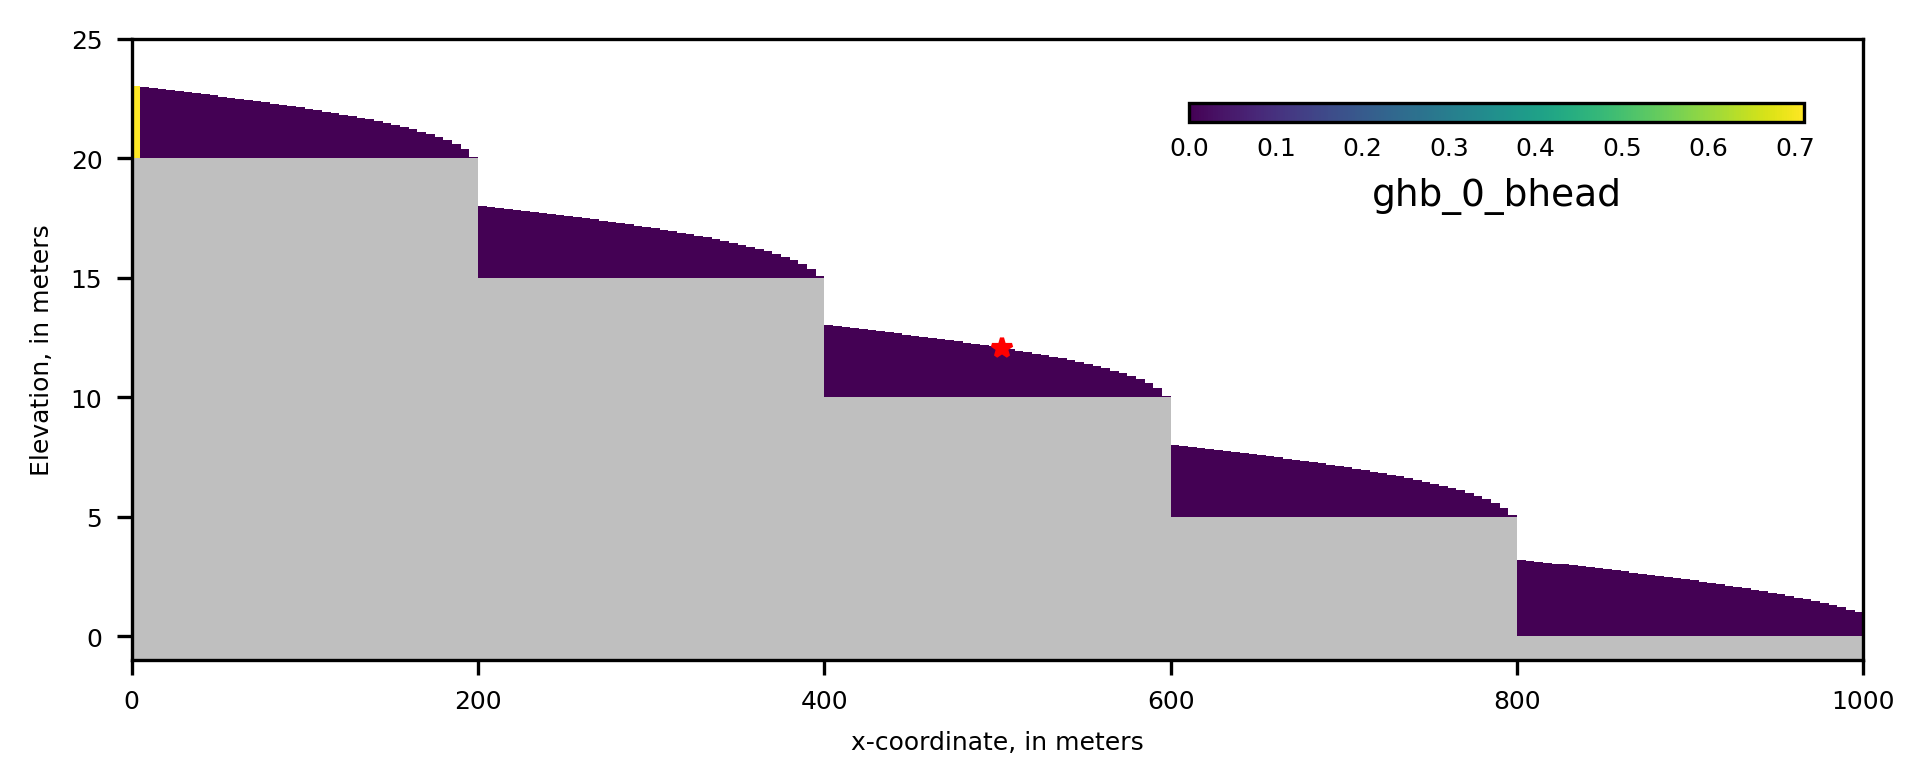

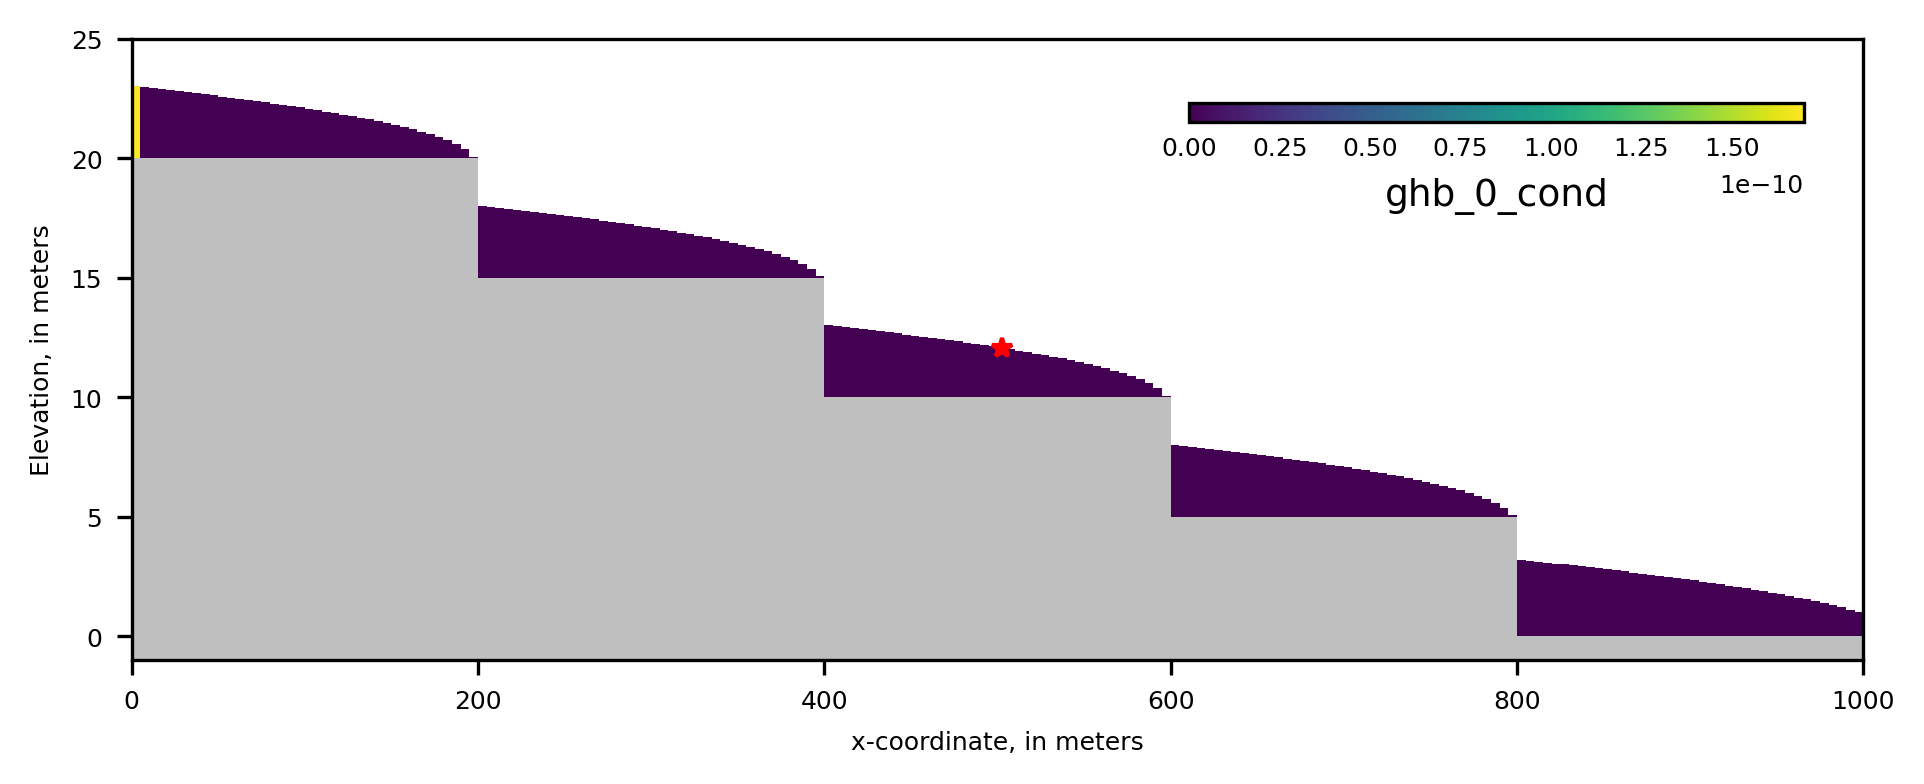

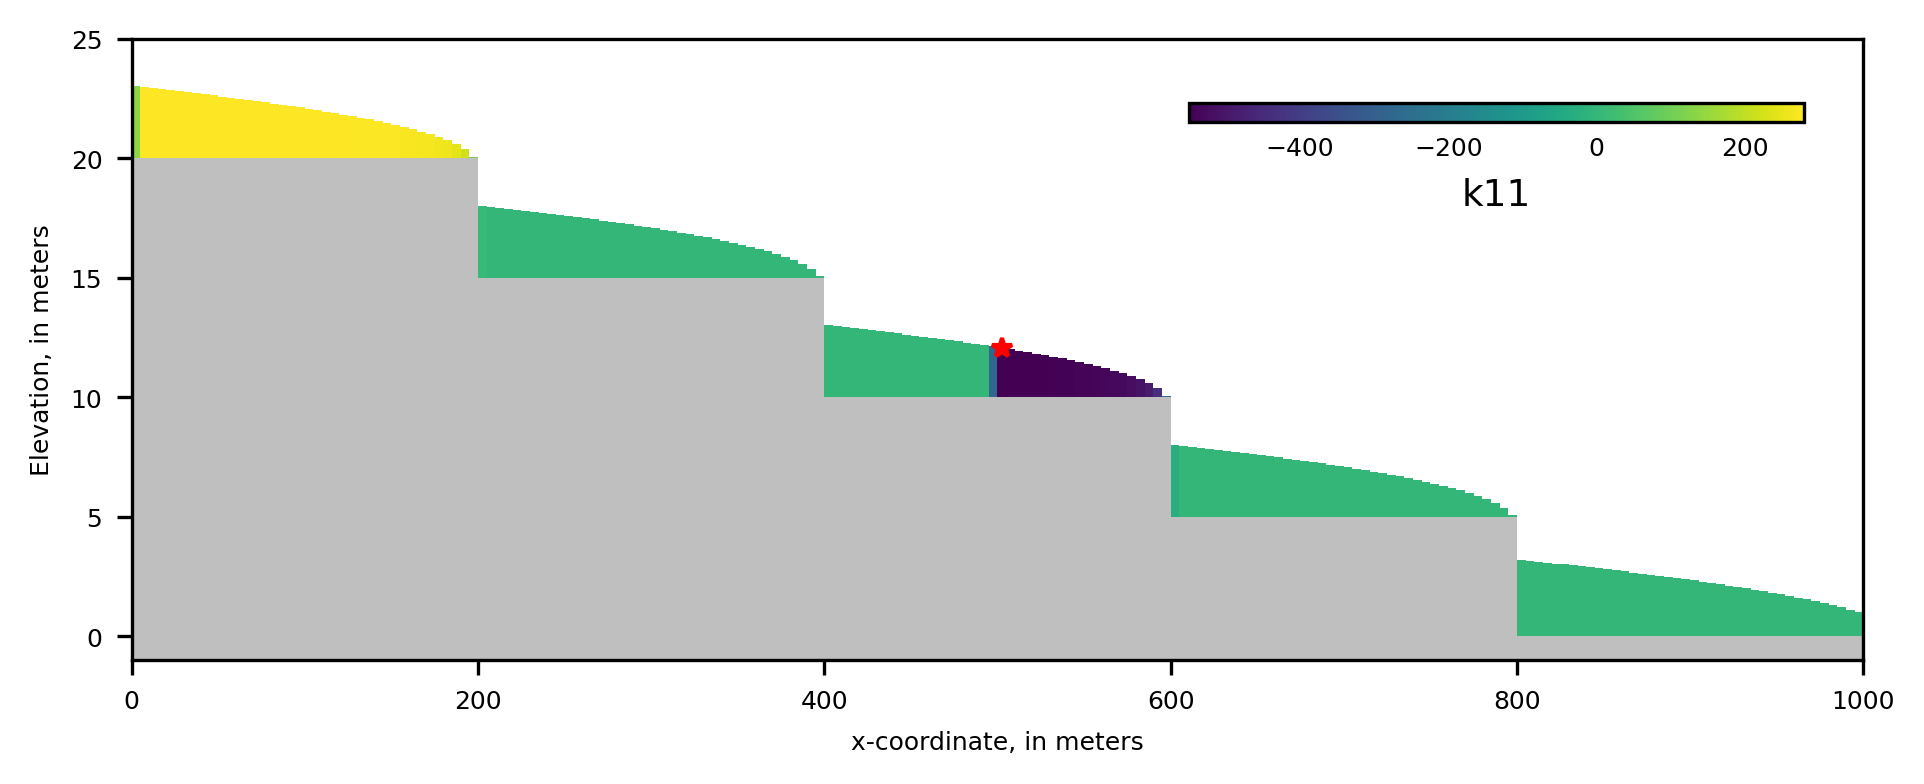

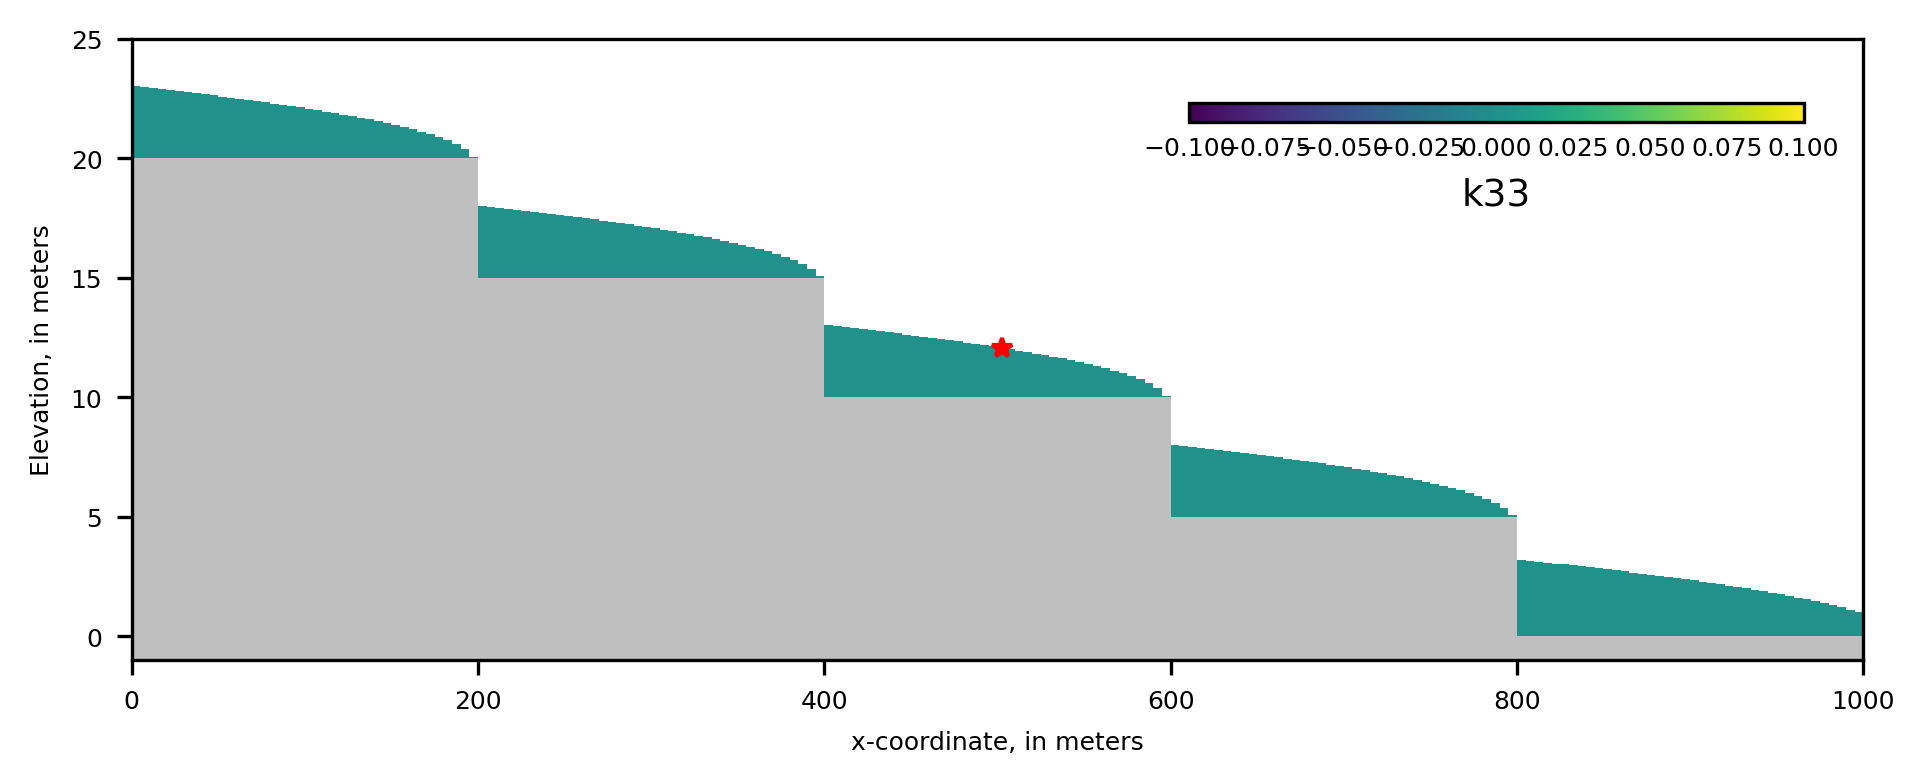

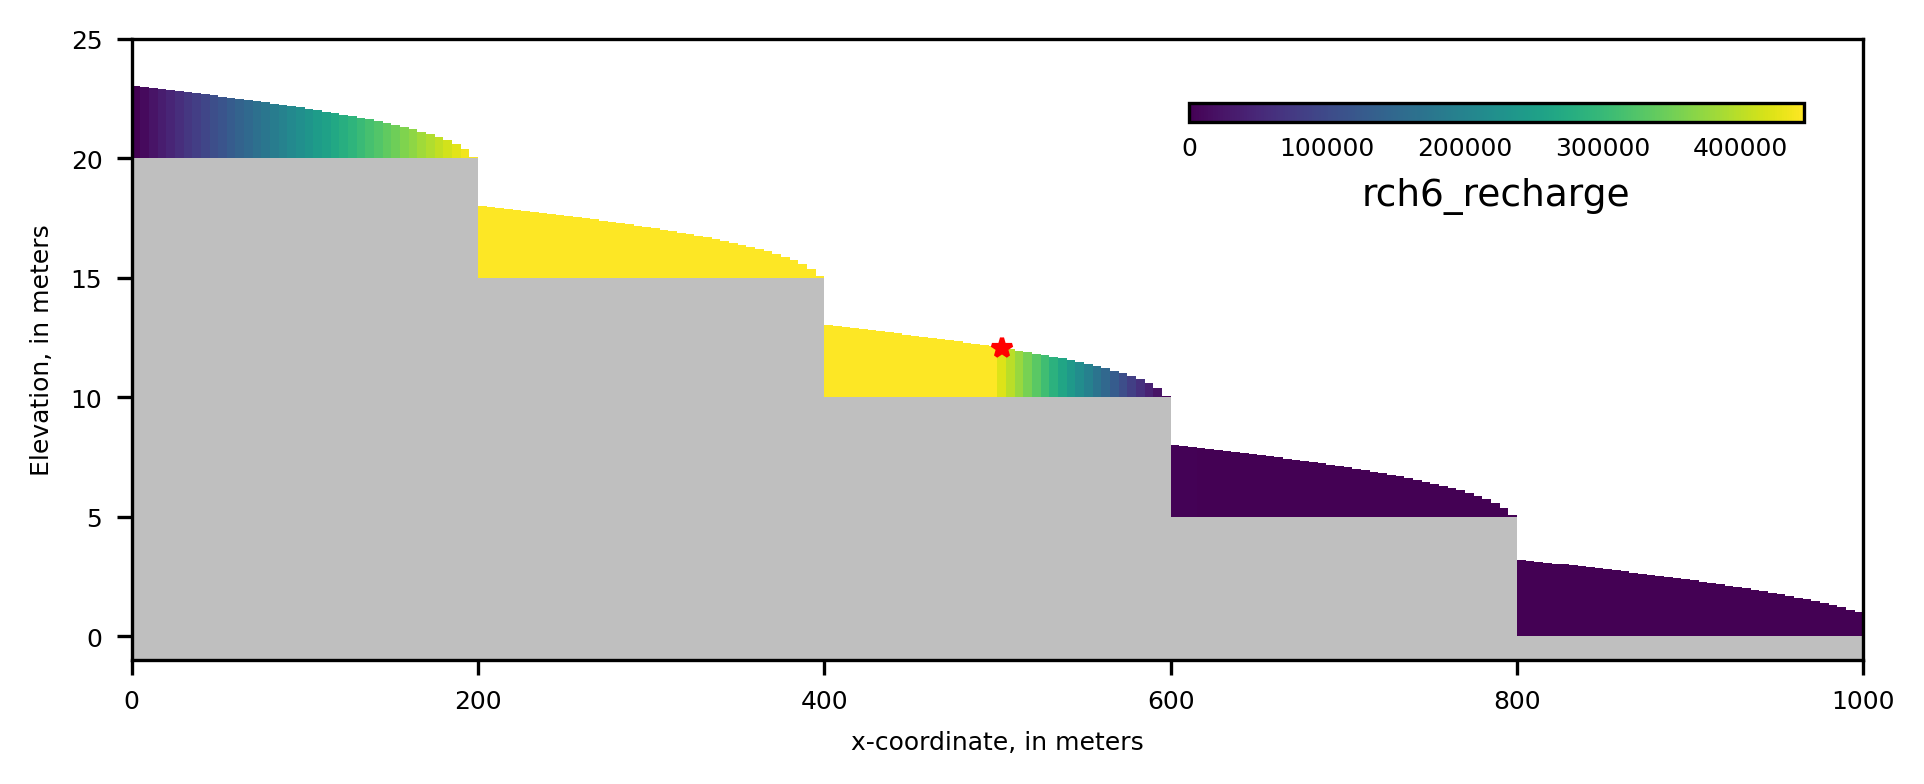

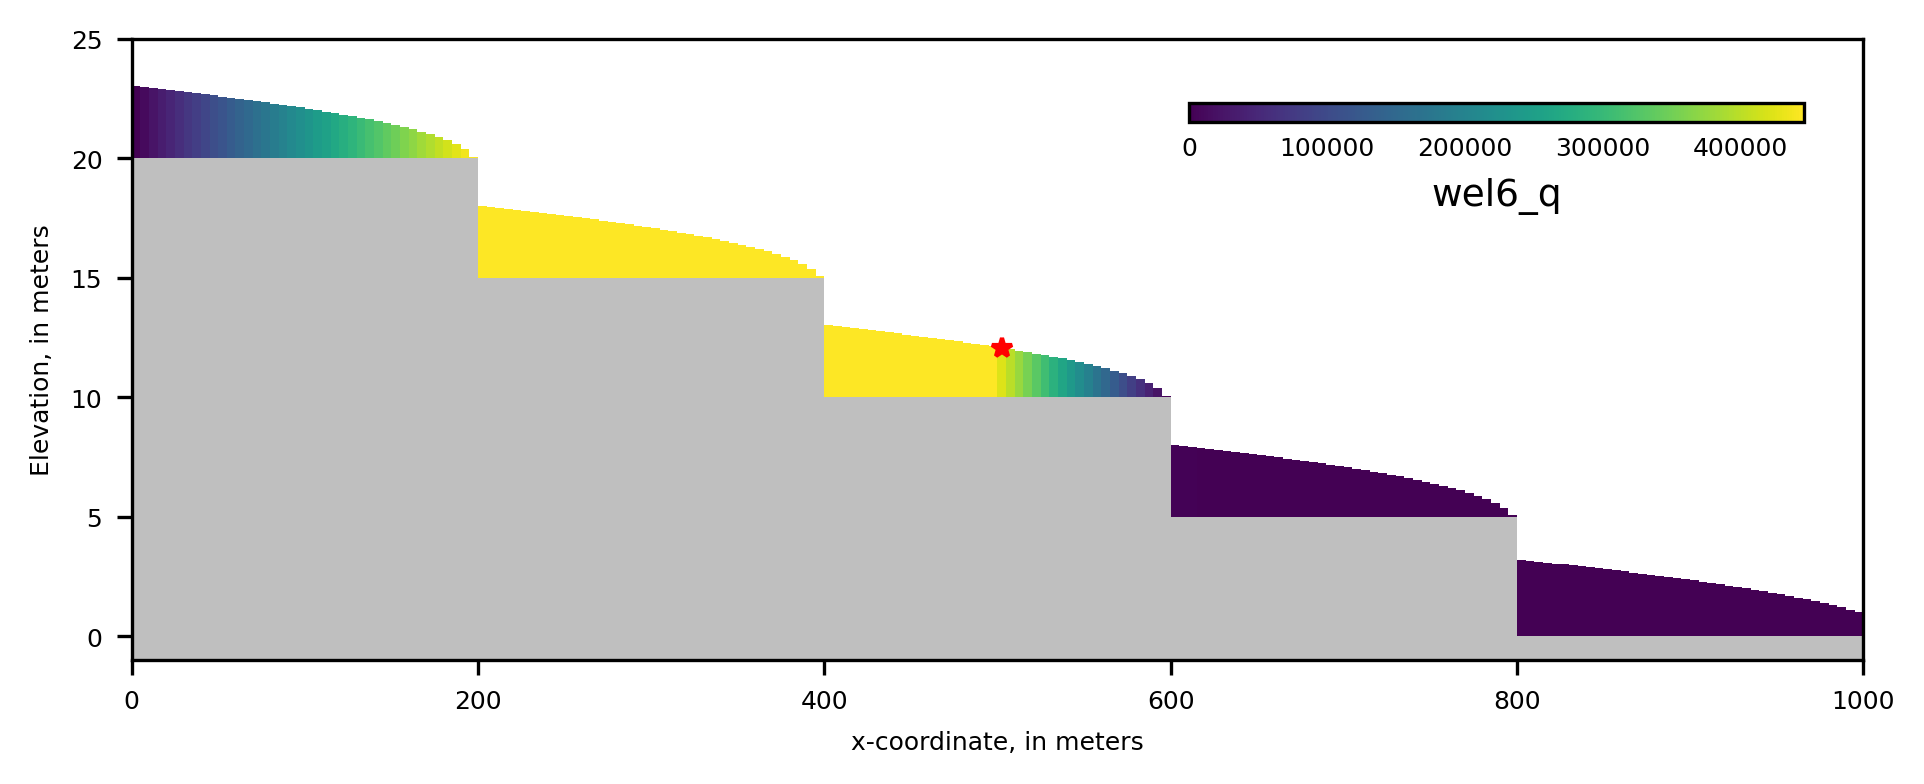

In [1154]:
grp = hdf["composite"]
plot_keys = [i for i in grp.keys() if len(grp[i].shape) == 3]
for pkey in plot_keys:
    arr = grp[pkey][:]
    for k,karr in enumerate(arr):
        plot_results(arr=karr,plot_head=False,arr_label=pkey,plot_pm=True,pm_col=pm_col)

#### This example has demonstrated the large amount of information one can glean from running `Mf6Adj` for a single direct head performance measure on a simple 2-D, SS model. 

#### One can imagine how powerful this could be for larger, more complex model applications. All for the computational cost of a single forward run and single adjoint solution. A screamin' deal!